In [187]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Dataset Source:  
This project uses the **CIC-IDS-2017** dataset, a publicly available network intrusion dataset created by the Canadian Institute for Cybersecurity. It contains real network traffic with both benign activity and multiple web-based attack scenarios.

Source: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset

In [171]:
data = pd.read_csv("data.csv")
data.columns = data.columns.str.strip()
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [172]:
# Columns selected
cols = [
    "Flow Duration", "Total Fwd Packets", "Total Backward Packets",
    "Total Length of Fwd Packets", "Total Length of Bwd Packets",
    "Flow Bytes/s", "Flow Packets/s", "Packet Length Mean",
    "Packet Length Variance", "Init_Win_bytes_forward",
    "Init_Win_bytes_backward",
]

X = data[cols].values
y = data["Label"].map({
    "BENIGN": 0,
    'Web Attack � Brute Force': 1,
    'Web Attack � XSS': 1,
    'Web Attack � Sql Injection': 1
}).values

In [173]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [175]:
rf = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 10,
    max_features = 'sqrt',
    min_samples_split = 2,
    class_weight = 'balanced',
    random_state=42,
    n_jobs=-1
    )

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [186]:
y_pred = rf.predict(X_test)
cr = classification_report(y_test, y_pred)
print("Classification Report: \n", cr)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)
y_prob = rf.predict_proba(X_test)[:, 1]
print("Probabilties: \n", y_prob[:5])
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print("Pre-Rec Score: ", pr_auc)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33611
           1       0.85      0.99      0.92       436

    accuracy                           1.00     34047
   macro avg       0.93      0.99      0.96     34047
weighted avg       1.00      1.00      1.00     34047

Confusion Matrix: 
 [[33536    75]
 [    5   431]]
Probabilties: 
 [0.         0.         0.00022258 0.01202184 0.        ]
Pre-Rec Score:  0.8901822931260229


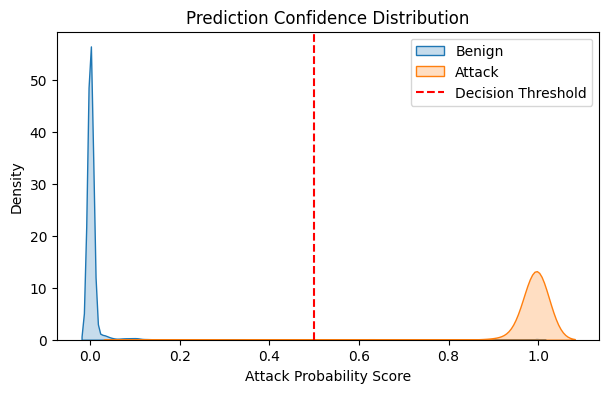

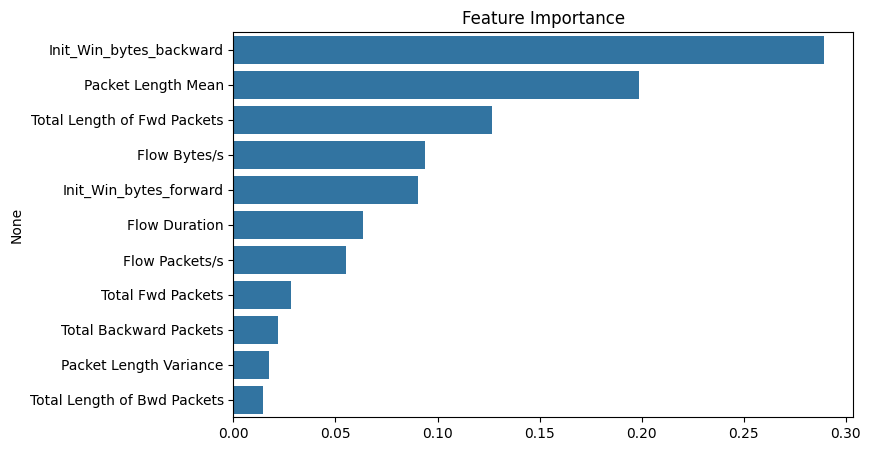

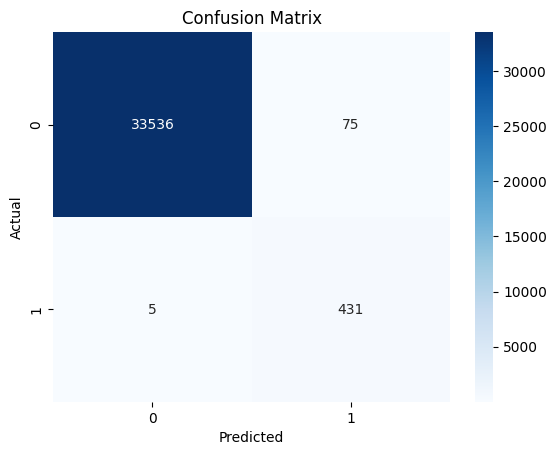

In [179]:

plt.figure(figsize=(7,4))
sns.kdeplot(y_prob[y_test == 0], label="Benign", fill=True)
sns.kdeplot(y_prob[y_test == 1], label="Attack", fill=True)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.xlabel("Attack Probability Score")
plt.ylabel("Density")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=cols).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importance")
plt.show()


sns.heatmap([cm[0],cm[1]], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [188]:
joblib.dump(rf, 'an_rf_model.joblib')
joblib.dump(scaler, 'an_rf_scaler.joblib')

['an_rf_scaler.joblib']